In [55]:
UNP_DIR = r"E:\MLCM\unprocessed_data"
PRO_DIR = r"E:\MLCM\processed_data"

In [56]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno

### HELPER FUNCTIONS

In [57]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## READ DATA

In [58]:
train = pd.read_csv(os.path.join(UNP_DIR, "train.csv"))
test = pd.read_csv(os.path.join(UNP_DIR, "test.csv"))
labels = pd.read_csv(os.path.join(UNP_DIR, "trainLabels.csv"))

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

# First few rows of the training dataset
labels.head()

Training data shape:  (9999, 146)
Testing data shape:  (1999, 146)


,id,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [59]:
test.columns = train.columns

def check_null_values(df):
    return df.isna().sum().sort_values(ascending=False)*100/len(df)

train_null = check_null_values(train)
train_labels_null = check_null_values(labels)
test_null = check_null_values(test)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = train.select_dtypes(include=numerics).columns.to_list()

object_columns = train.select_dtypes(include=object).columns

train[object_columns] = train[object_columns].astype(str)
test[object_columns] = test[object_columns].astype(str)

boolean_columns = [col for col in object_columns if train[col][0].isupper()]
alphanumeric_columns = [col for col in object_columns if not train[col][0].isupper()]

for col in boolean_columns:
    train[col].replace({'YES':1, 'NO':0,'nan':None},inplace=True)
    test[col].replace({'YES':1, 'NO':0,'nan':None},inplace=True)

## VISUALIZING DATA

In [66]:
train.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 146 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    id      9999 non-null   int64  
 1    x1      8573 non-null   float64
 2    x2      8573 non-null   float64
 3    x3      9999 non-null   object 
 4    x4      9999 non-null   object 
 5    x5      9999 non-null   float64
 6    x6      9999 non-null   float64
 7    x7      9999 non-null   float64
 8    x8      9999 non-null   float64
 9    x9      9999 non-null   float64
 10   x10     8573 non-null   float64
 11   x11     8573 non-null   float64
 12   x12     8573 non-null   float64
 13   x13     8573 non-null   float64
 14   x14     8573 non-null   float64
 15   x15     9999 non-null   int64  
 16   x16     9999 non-null   float64
 17   x17     9999 non-null   int64  
 18   x18     9999 non-null   int64  
 19   x19     9999 non-null   float64
 20   x20     9999 non-null   float64
 21   x21     9999

In [36]:
train_missing= missing_values_table(train)
train_missing

Your selected dataframe has 146 columns.
There are 40 columns that have missing values.


,Missing Values,% of Total Values
x1,1426,14.3
x14,1426,14.3
x2,1426,14.3
x25,1426,14.3
x24,1426,14.3
x26,1426,14.3
x13,1426,14.3
x12,1426,14.3
x11,1426,14.3
x10,1426,14.3


In [37]:
test_missing= missing_values_table(test)
test_missing

Your selected dataframe has 146 columns.
There are 40 columns that have missing values.


,Missing Values,% of Total Values
x1,294,14.7
x14,294,14.7
x2,294,14.7
x25,294,14.7
x24,294,14.7
x26,294,14.7
x13,294,14.7
x12,294,14.7
x11,294,14.7
x10,294,14.7


<Axes: >

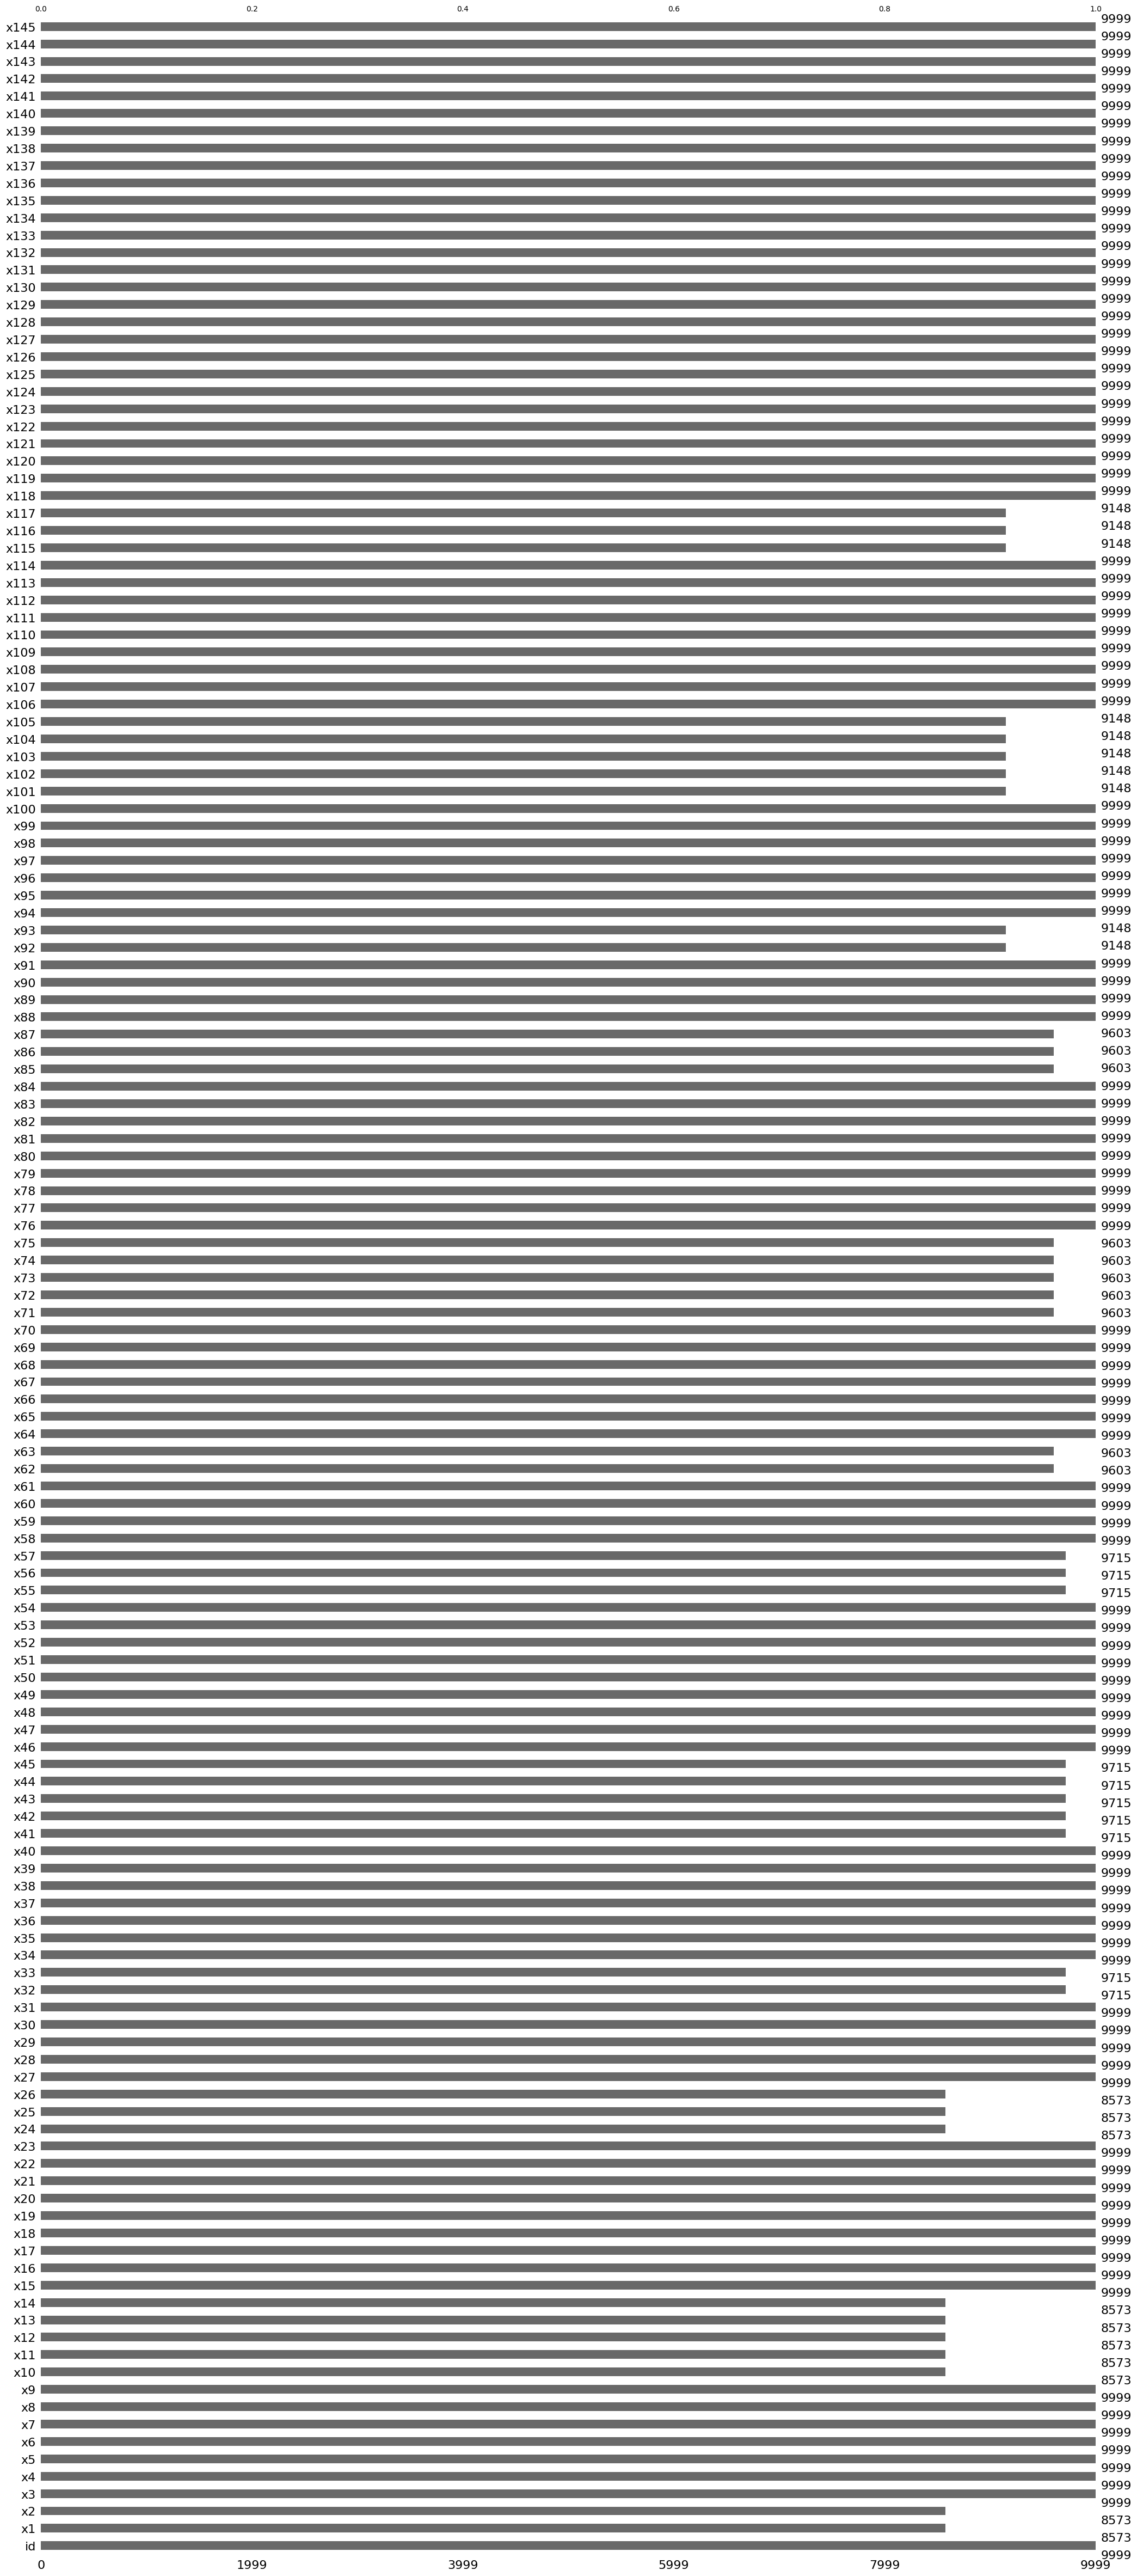

In [38]:
msno.bar(train)

<Axes: >

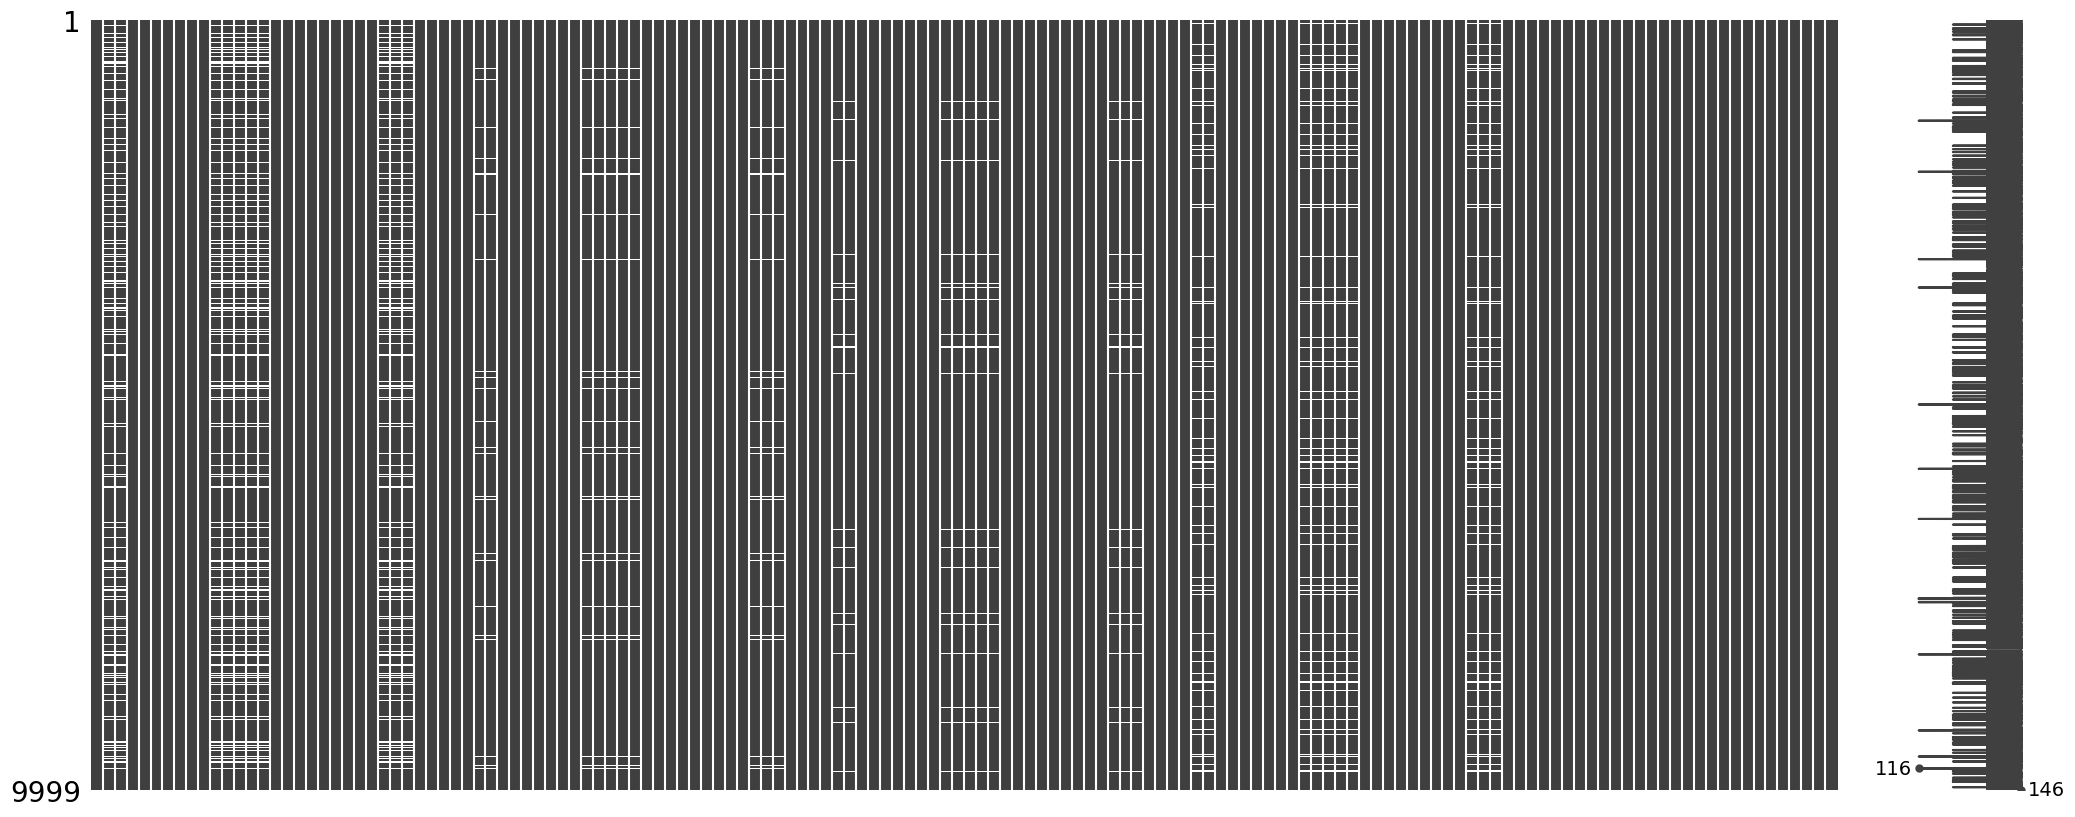

In [39]:
msno.matrix(train)

<Axes: >

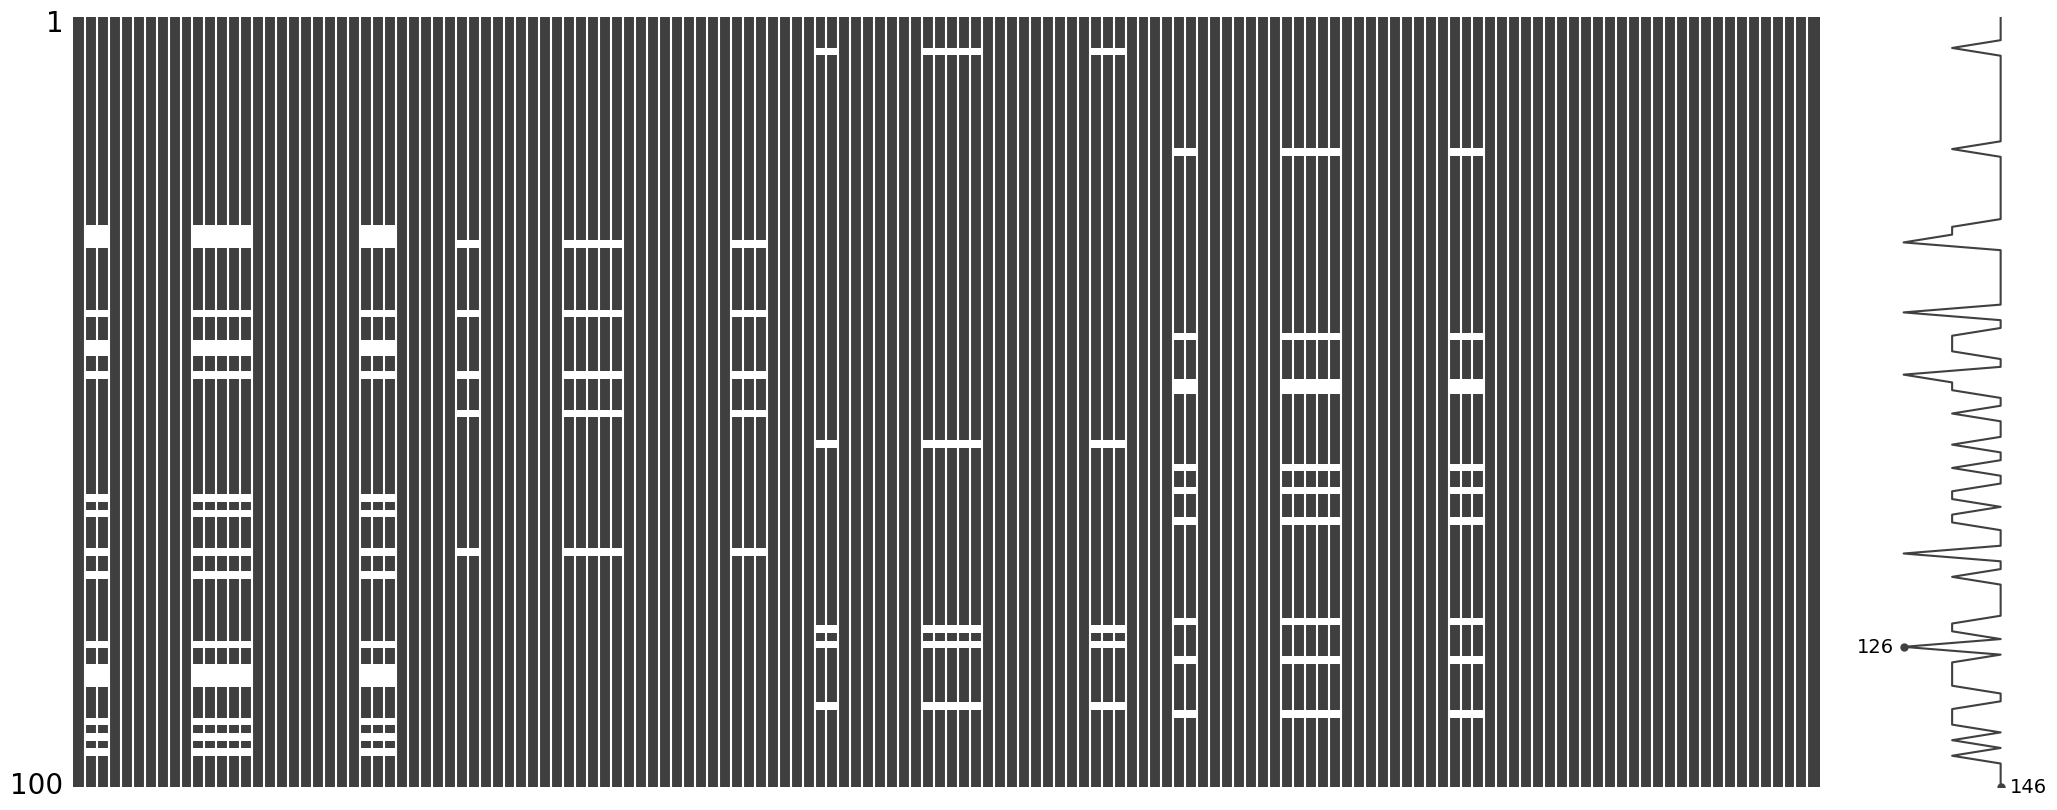

In [40]:
msno.matrix(train.sample(100))

<Axes: >

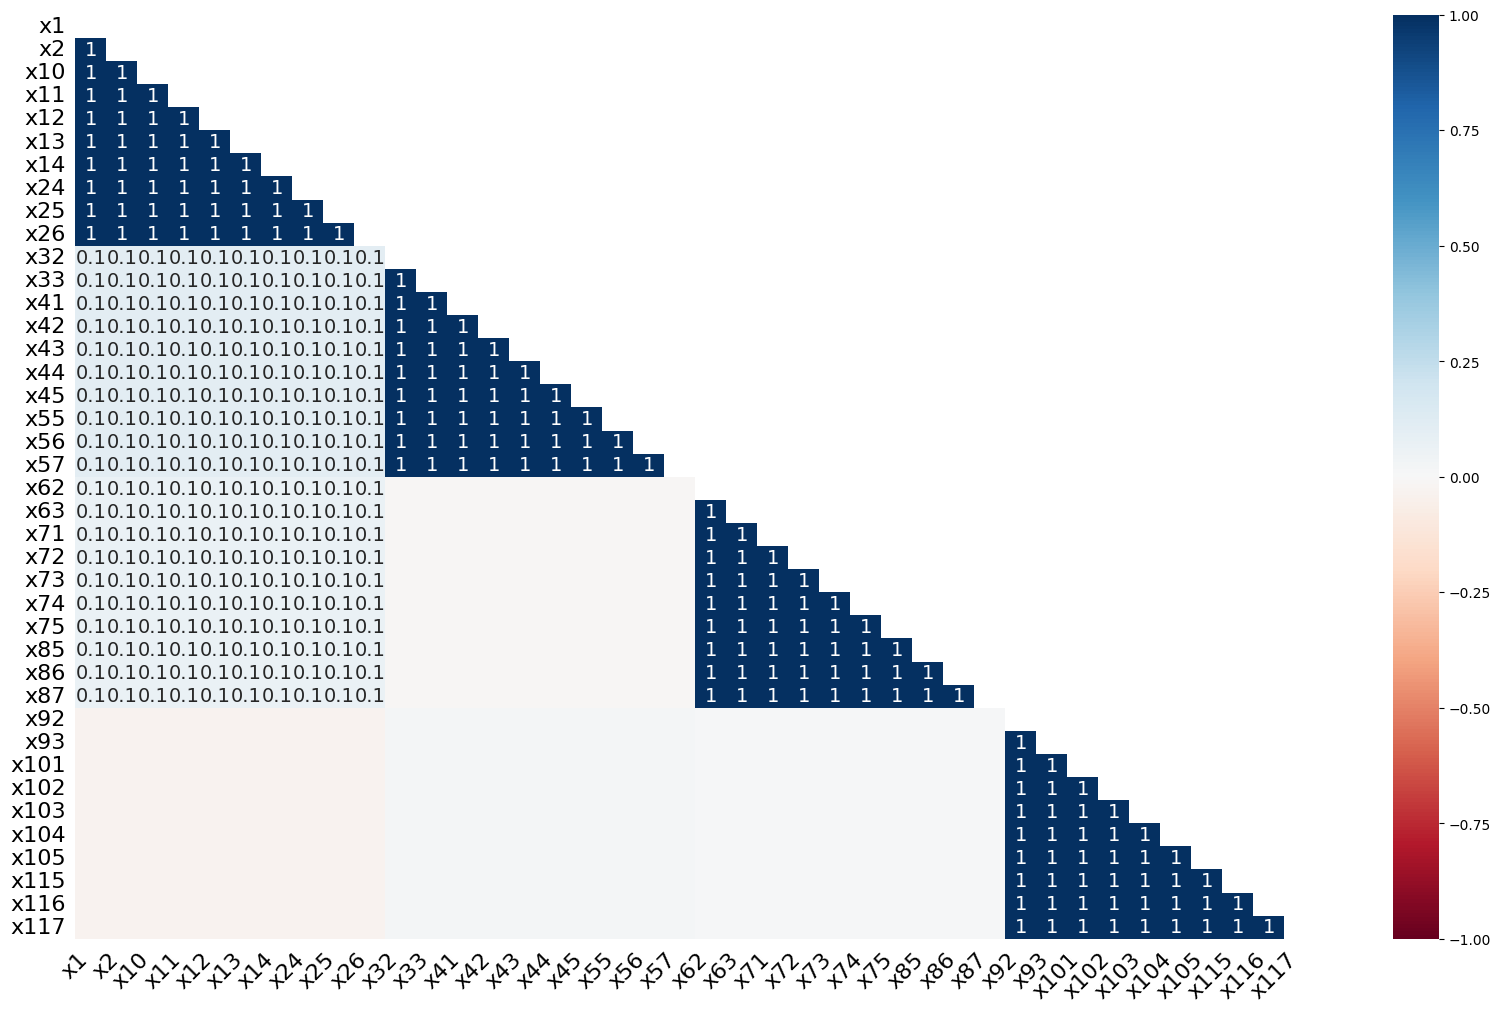

In [41]:
msno.heatmap(train)

## IMPUTATION

In [104]:
train_knn = train.copy(deep=True)

In [106]:
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer

train_MICE = train.copy(deep=True)

# IterativeImputer
num_imp = IterativeImputer(initial_strategy='mean',max_iter=10)
bool_imp = IterativeImputer(initial_strategy='most_frequent',max_iter=10)
train_MICE[numeric_columns] = num_imp.fit_transform(train_MICE[numeric_columns])
train_MICE[boolean_columns] = bool_imp.fit_transform(train_MICE[boolean_columns])
train_MICE_FINAL = train_MICE[numeric_columns+boolean_columns]

train_knn = train.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2)
train_knn[numeric_columns] = knn_imputer.fit_transform(train_knn[numeric_columns])

train_knn[boolean_columns] = knn_imputer.fit_transform(train_knn[boolean_columns])
train_knn_FINAL = train_knn[numeric_columns+boolean_columns]


# SimpleImputer
# from sklearn.impute import SimpleImputer
# simple_imputer = SimpleImputer(strategy='mean')
# train_knn[numeric_columns] = simple_imputer.fit_transform(train_knn[numeric_columns])

e:\MLCM\.venv\lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# VISUALIZATION AFTER IMPUTING

In [94]:
train_knn.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 146 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    id      9999 non-null   float64
 1    x1      9999 non-null   float64
 2    x2      9999 non-null   float64
 3    x3      9999 non-null   object 
 4    x4      9999 non-null   object 
 5    x5      9999 non-null   float64
 6    x6      9999 non-null   float64
 7    x7      9999 non-null   float64
 8    x8      9999 non-null   float64
 9    x9      9999 non-null   float64
 10   x10     9999 non-null   float64
 11   x11     9999 non-null   float64
 12   x12     9999 non-null   float64
 13   x13     9999 non-null   float64
 14   x14     9999 non-null   float64
 15   x15     9999 non-null   float64
 16   x16     9999 non-null   float64
 17   x17     9999 non-null   float64
 18   x18     9999 non-null   float64
 19   x19     9999 non-null   float64
 20   x20     9999 non-null   float64
 21   x21     9999

In [90]:
train_MICE.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 146 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    id      9999 non-null   float64
 1    x1      9999 non-null   float64
 2    x2      9999 non-null   float64
 3    x3      9999 non-null   object 
 4    x4      9999 non-null   object 
 5    x5      9999 non-null   float64
 6    x6      9999 non-null   float64
 7    x7      9999 non-null   float64
 8    x8      9999 non-null   float64
 9    x9      9999 non-null   float64
 10   x10     9999 non-null   float64
 11   x11     9999 non-null   float64
 12   x12     9999 non-null   float64
 13   x13     9999 non-null   float64
 14   x14     9999 non-null   float64
 15   x15     9999 non-null   float64
 16   x16     9999 non-null   float64
 17   x17     9999 non-null   float64
 18   x18     9999 non-null   float64
 19   x19     9999 non-null   float64
 20   x20     9999 non-null   float64
 21   x21     9999

<Axes: >

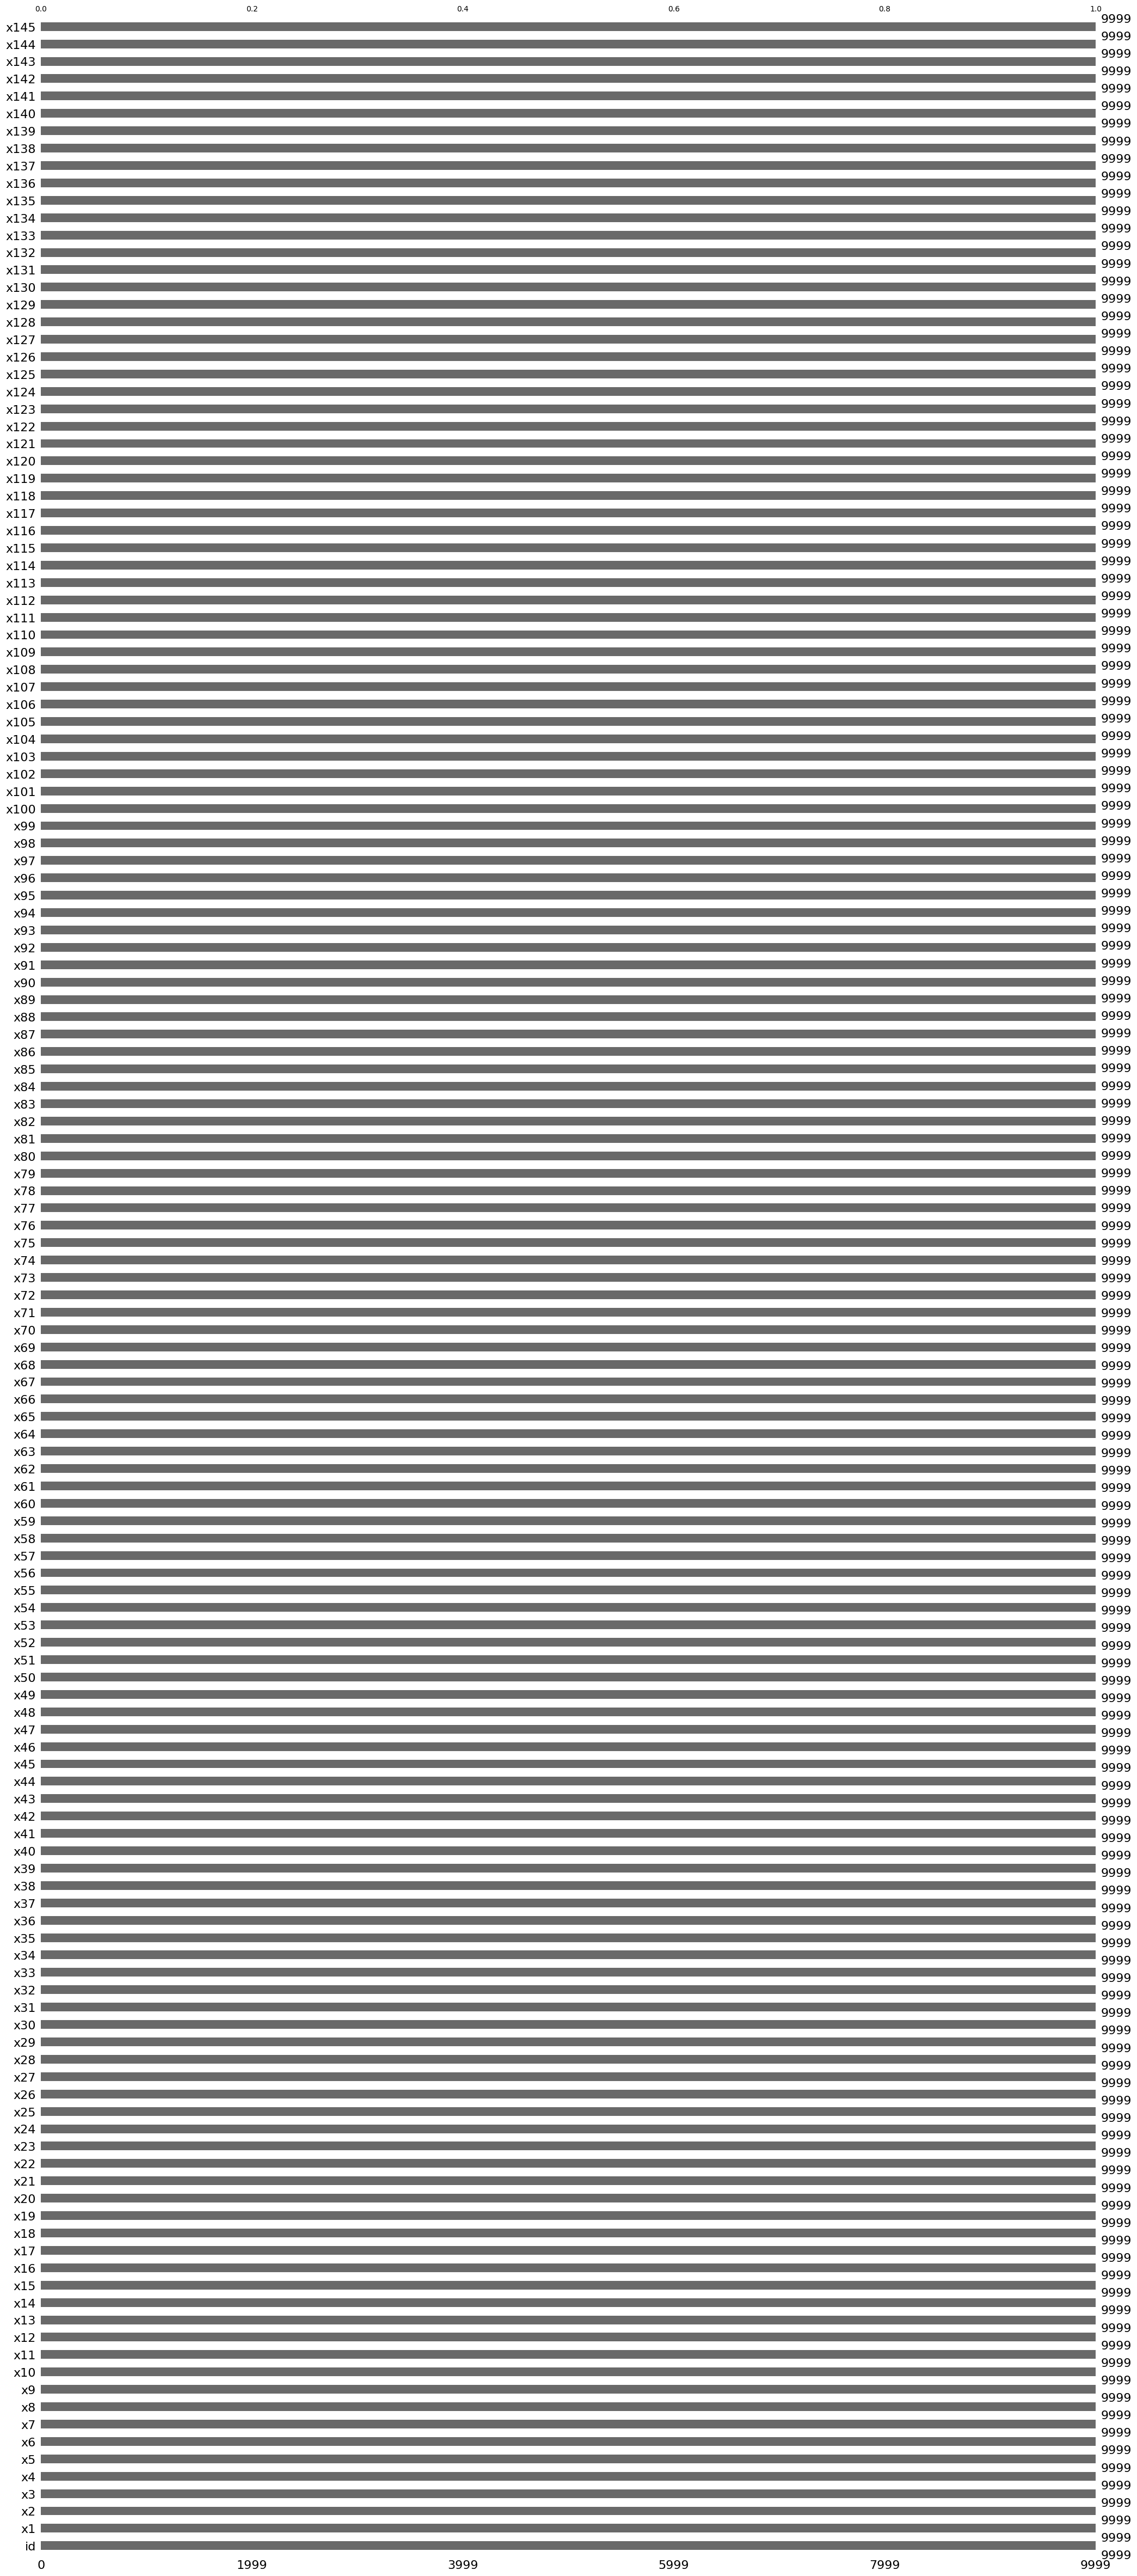

In [85]:
msno.bar(train_knn)

<Axes: >

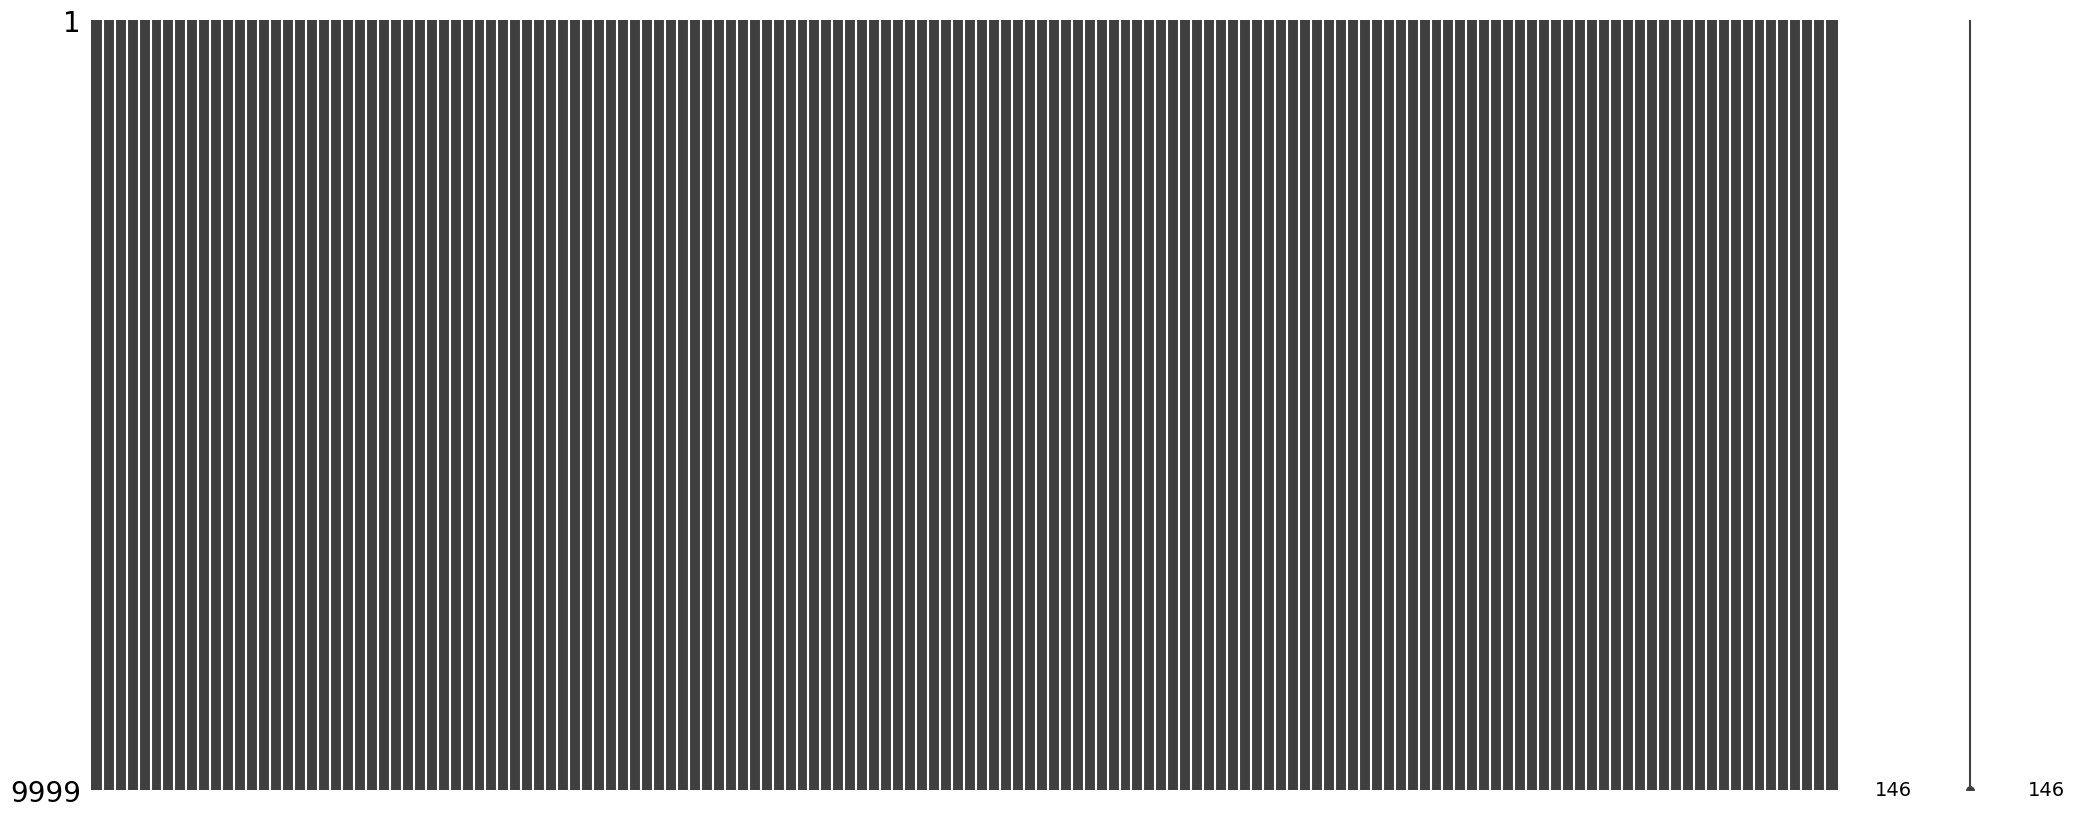

In [78]:
msno.matrix(train_knn)

<Axes: >

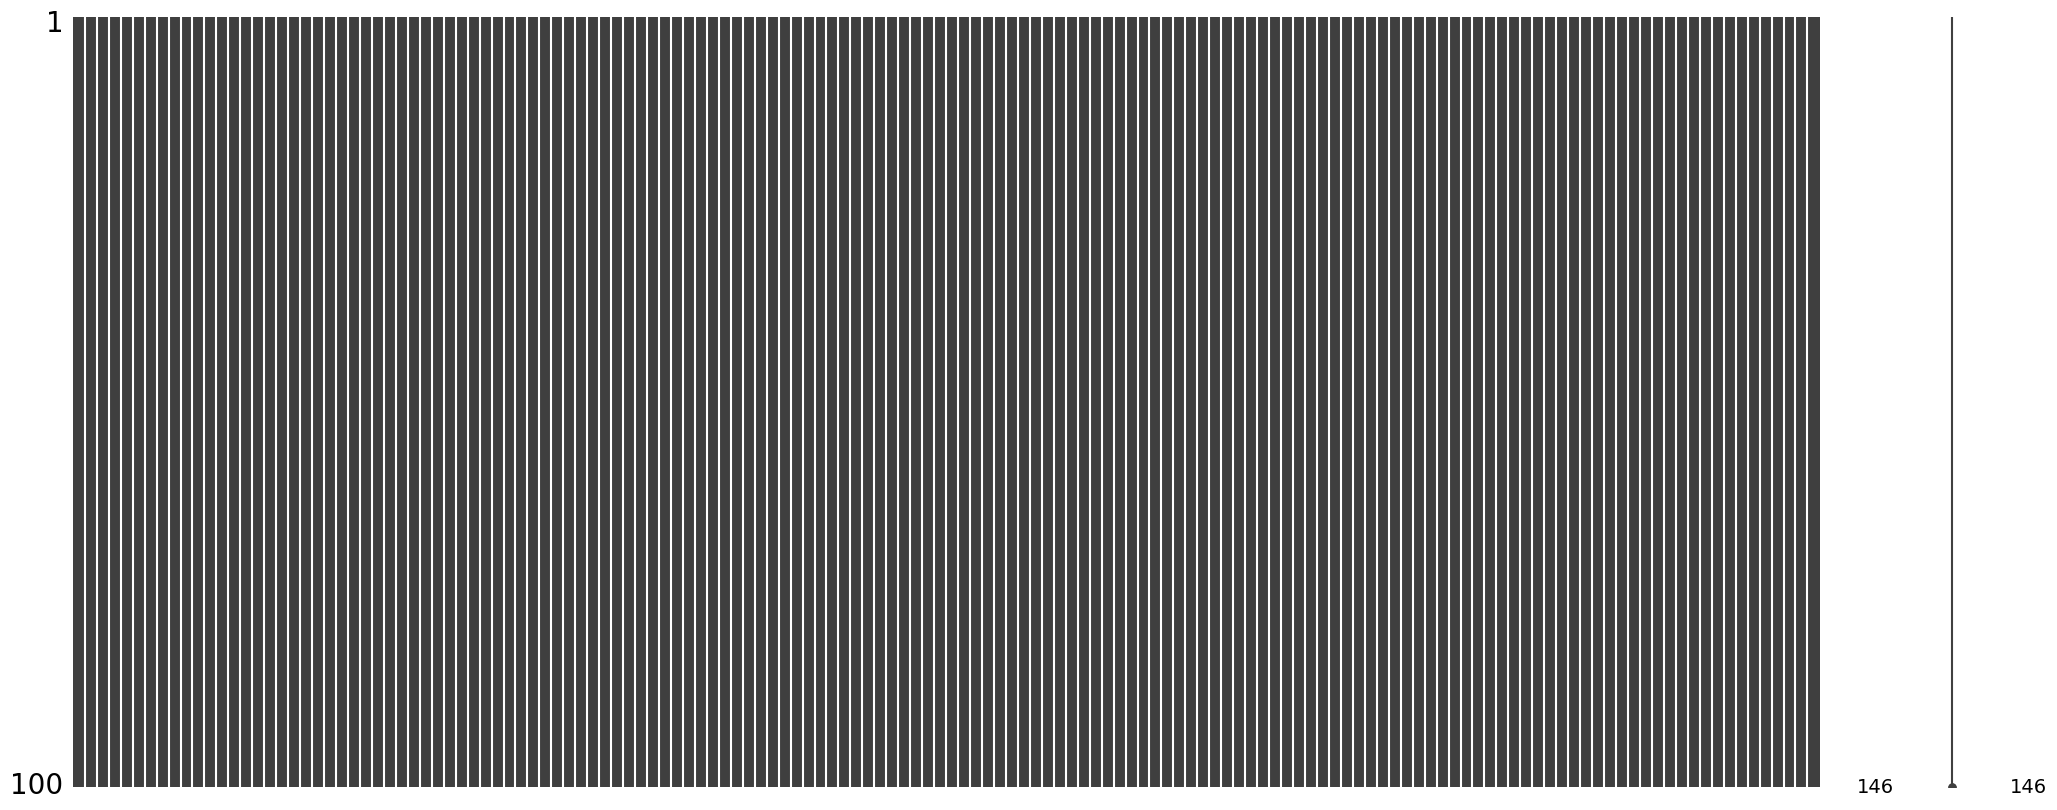

In [79]:
msno.matrix(train_knn.sample(100))

e:\MLCM\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
e:\MLCM\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

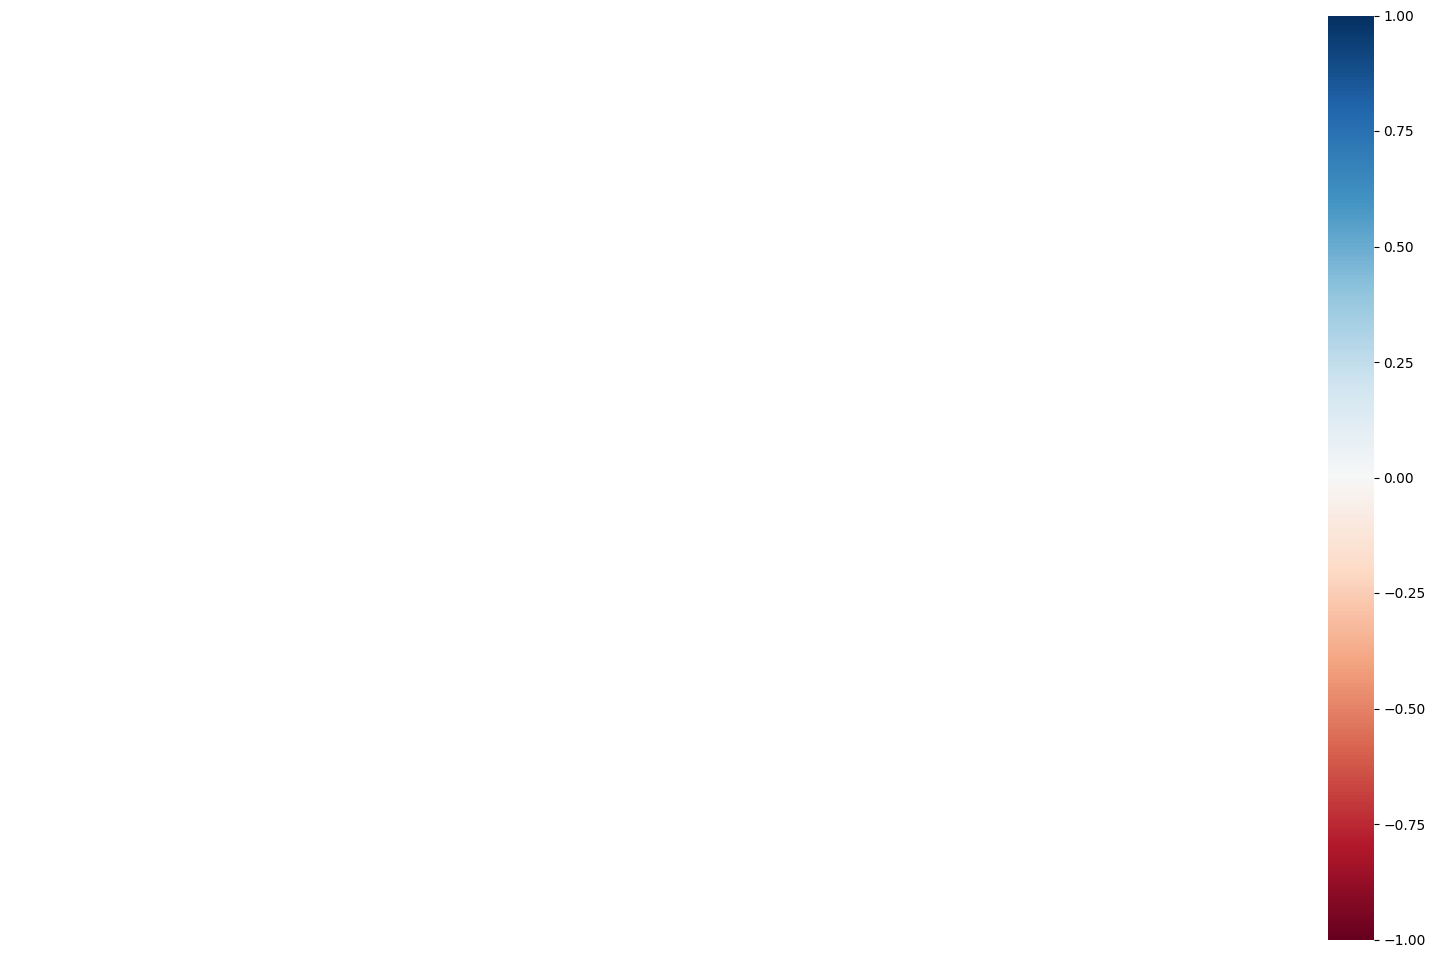

In [107]:
msno.heatmap(train_knn_FINAL)

In [110]:
print(train_MICE_FINAL.shape)

(9999, 136)


e:\MLCM\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
e:\MLCM\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

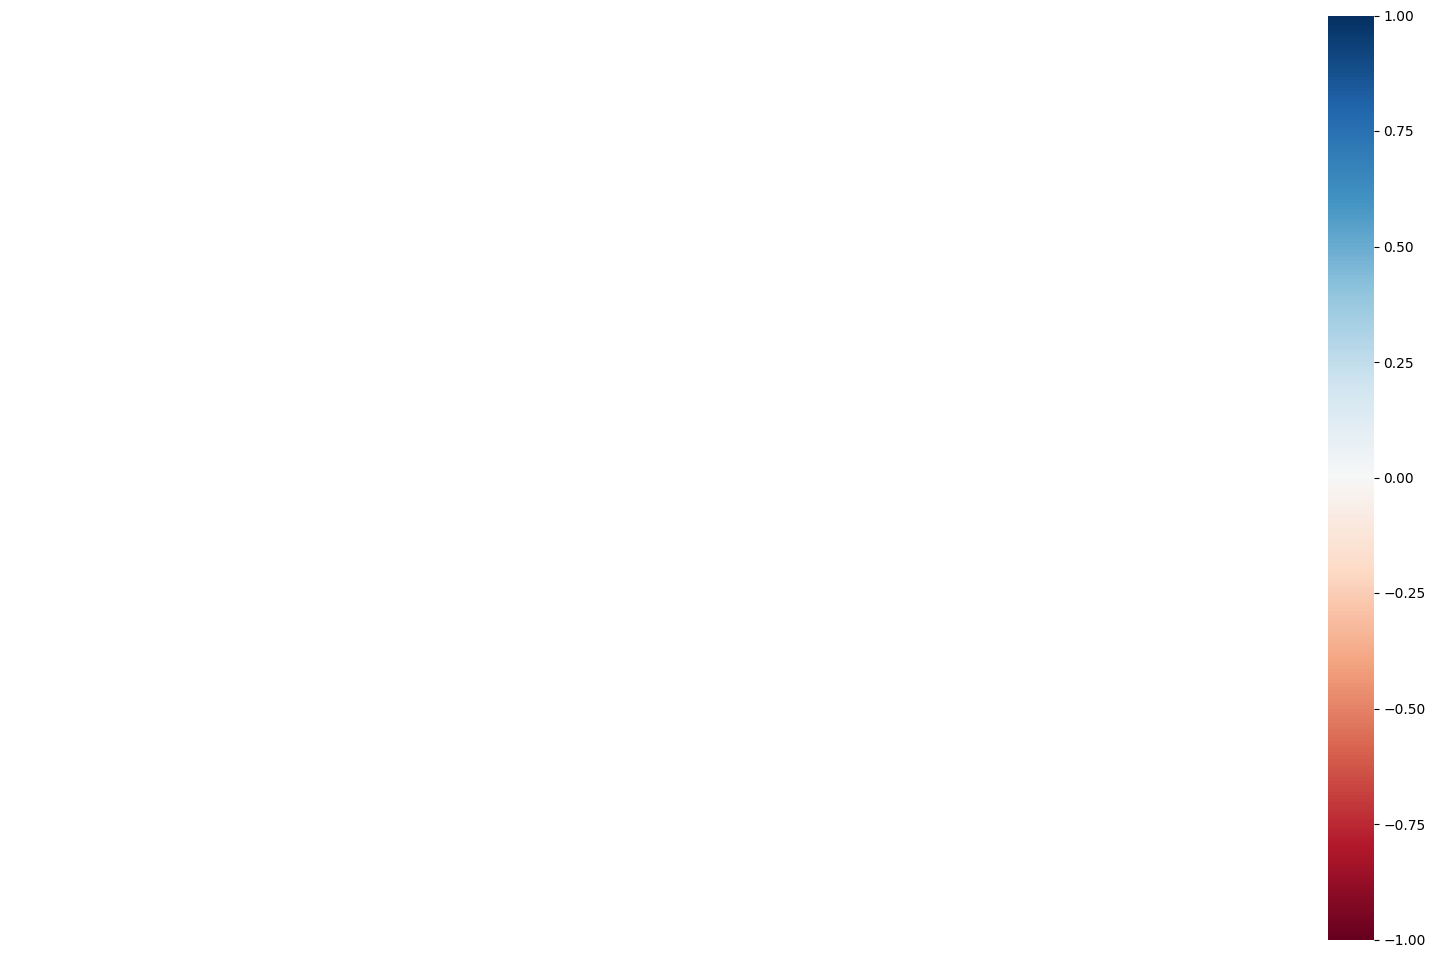

In [111]:
msno.heatmap(train_MICE_FINAL[136:], labels=True)